In [1]:
## The following is NOT needed if installed CmdStanPy with Conda as it does everything

## Install CmdStanPy
# %pip install --upgrade cmdstanpy

## Download CmdStan and build utilities - RUN FIRST TIME ONLY
# import cmdstanpy
# cmdstanpy.install_cmdstan(compiler=True)  # only valid on Windows

## Install to allow progress bars to work
# %pip install ipywidgets

In [2]:
import os
from cmdstanpy import CmdStanModel
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import describe
import multiprocessing

In [3]:
from thinning import sample_hawkes_process_thinning_true_vectorised
from utils import exp_kernel_vectorised, constant_background, plot_counting_process
from mle import log_likelihood

## Posterior sampling with Stan - initial attempt

Load stan model.

In [31]:
stan_file = os.path.join('.', 'simple_exp_hawkes.stan')
model_compiled = CmdStanModel(stan_file=stan_file,
                                # If you want multi-thread option, need to recompile
                                cpp_options={'STAN_THREADS': 'TRUE'},
                                # turn off below to avoid recompiling
                                # force_compile=True
                                )

13:38:19 - cmdstanpy - INFO - compiling stan file C:\Users\ethan\ONEDRI~1\Maths\YEAR4~1\Project\HAWKES~1\simple_exp_hawkes.stan to exe file C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\simple_exp_hawkes.exe
13:38:48 - cmdstanpy - INFO - compiled model executable: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\simple_exp_hawkes.exe


In [32]:
model_compiled.exe_info()

{'stan_version_major': '2',
 'stan_version_minor': '34',
 'stan_version_patch': '1',
 'STAN_THREADS': 'true',
 'STAN_MPI': 'false',
 'STAN_OPENCL': 'false',
 'STAN_NO_RANGE_CHECKS': 'false',
 'STAN_CPP_OPTIMS': 'false'}

Generate Hawkes process data.

In [33]:
hawkes_seed=244659525681607163626346801839259531332

max_T = 100
hawkes_realisation = sample_hawkes_process_thinning_true_vectorised(max_T, constant_background, exp_kernel_vectorised, seed=hawkes_seed)
N = len(hawkes_realisation)

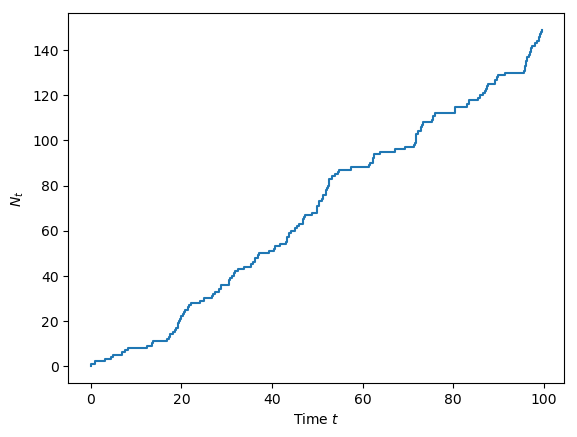

In [34]:
plot_counting_process(hawkes_realisation)

Save data and initial values in right format for Stan.

In [35]:
data = {
    "N" : N,
    "events_list" : hawkes_realisation,
    "max_T" : max_T
}

inits = {"mu": 0.5, "alpha": 0.5, "delta": 0.5}


MCMC sampling with Stan.

In [36]:
warmup=500
fit = model_compiled.sample(data=data,
                            seed=123,
                            chains=2,
                            iter_warmup=warmup,
                            iter_sampling=3*warmup,
                            inits=inits,
                            ## uncomment to see cmd line updates instead of progress bars
                            # refresh=500,
                            # show_console=True,
                            save_warmup=True)

13:38:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:41:13 - cmdstanpy - INFO - CmdStan done processing.


In [37]:
os.environ['STAN_NUM_THREADS']

'2'

WARNING - only run the following few code cells if compiled with multi-thread option!

Seeing if using `parallel_chains` is faster...

In [38]:
warmup=500
fit = model_compiled.sample(data=data,
                            seed=123,
                            chains=2,
                            parallel_chains=2,
                            iter_warmup=warmup,
                            iter_sampling=3*warmup,
                            inits=inits,
                            ## uncomment to see cmd line updates instead of progress bars
                            # refresh=500,
                            # show_console=True,
                            save_warmup=True)

13:41:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:43:33 - cmdstanpy - INFO - CmdStan done processing.


In [39]:
os.environ['STAN_NUM_THREADS']

'2'

In [40]:
multiprocessing.cpu_count()

12

~~Running in parallel actually slowed down in the above.~~ Actually think it already runs 2 chains in parallel (actually defaults to multiprocessing.cpu_count() above).

Now increasing `threads_per_chain`, but according to documentation this shouldn't change anything since Stan model file doesn't use multithread-able code.

In [16]:
warmup=500
fit = model_compiled.sample(data=data,
                            seed=123,
                            chains=2,
                            parallel_chains=2,
                            threads_per_chain=6,
                            iter_warmup=warmup,
                            iter_sampling=3*warmup,
                            inits=inits,
                            ## uncomment to see cmd line updates instead of progress bars
                            # refresh=500,
                            # show_console=True,
                            save_warmup=True)

20:13:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

20:13:51 - cmdstanpy - INFO - CmdStan done processing.


In [17]:
os.environ['STAN_NUM_THREADS']

'12'

Took the same time even though the recorded number of threads is indeed higher.

In [41]:
df = fit.draws_pd(inc_warmup=True)
# df = fit.draws_pd()

Produce trace plots for each parameter.

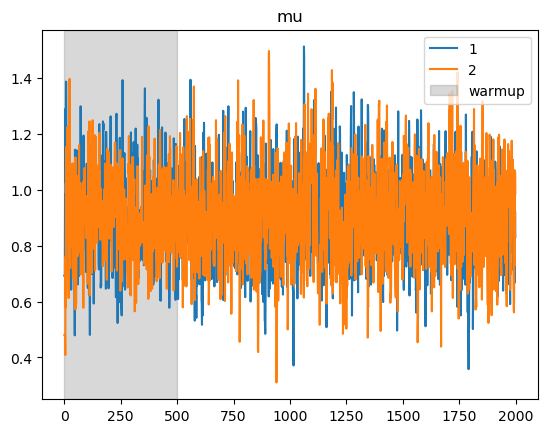

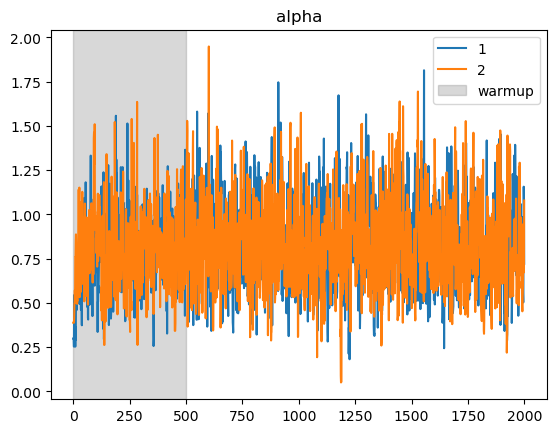

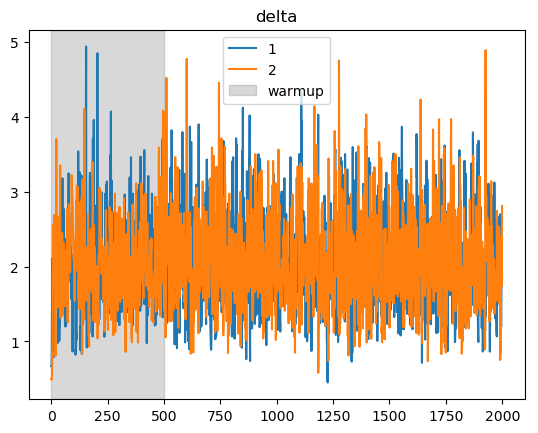

In [42]:
df_chain1 = df[df['chain__'] == 1.0]
df_chain2 = df[df['chain__'] == 2.0]

plt.figure()
plt.plot(df_chain1['mu'].values, label=1)
plt.plot(df_chain2['mu'].values, label=2)
plt.axvspan(xmin=0, xmax=warmup, color='gray', alpha=0.3, label='warmup')
plt.legend()
plt.title('mu')
plt.show()

plt.figure()
plt.plot(df_chain1['alpha'].values, label=1)
plt.plot(df_chain2['alpha'].values, label=2)
plt.axvspan(xmin=0, xmax=warmup, color='gray', alpha=0.3, label='warmup')
plt.legend()
plt.title('alpha')
plt.show()

plt.figure()
plt.plot(df_chain1['delta'].values, label=1)
plt.plot(df_chain2['delta'].values, label=2)
plt.axvspan(xmin=0, xmax=warmup, color='gray', alpha=0.3, label='warmup')
plt.legend()
plt.title('delta')
plt.show()

Compute summary statistics.

In [43]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-79.915700,0.041301,1.347780,-82.467500,-79.583800,-78.52460,1064.92,5.31213,1.001510
mu,0.905339,0.004372,0.164027,0.640606,0.906126,1.16926,1407.47,7.02090,0.999500
alpha,0.825395,0.006673,0.246619,0.455716,0.802714,1.25969,1366.02,6.81413,0.999623
delta,2.077560,0.017026,0.625646,1.155530,2.018250,3.20417,1350.26,6.73551,0.999549
hawkes_log_likelihood,-80.097600,0.033915,1.149130,-82.191200,-79.825000,-78.83150,1148.06,5.72686,1.001640


Run diagnose to check for potential problems with sampling.

In [44]:
print(fit.diagnose())

Processing csv files: C:\Users\ethan\AppData\Local\Temp\tmpugd9n064\simple_exp_hawkess_knnxcw\simple_exp_hawkes-20240410134118_1.csvWarning: non-fatal error reading adaptation data
, C:\Users\ethan\AppData\Local\Temp\tmpugd9n064\simple_exp_hawkess_knnxcw\simple_exp_hawkes-20240410134118_2.csvWarning: non-fatal error reading adaptation data


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



No problems with sampling posteriors detected.

Now we wish to plot the empirical distributions that were sampled. We plot with and without warmup side by side.

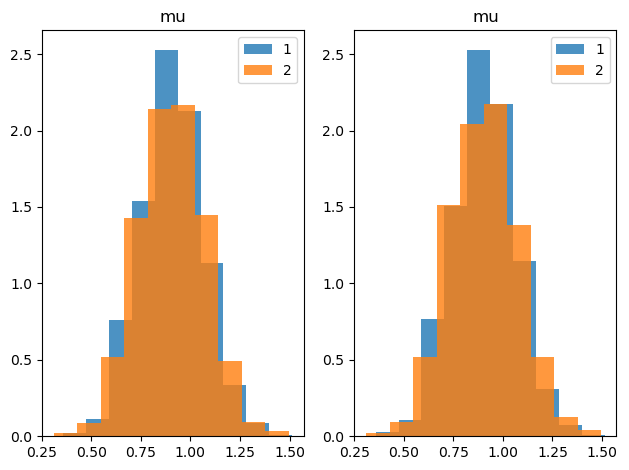

DescribeResult(nobs=3000, minmax=(0.310588, 1.51278), mean=0.9053393833333333, variance=0.026904918312982046, skewness=0.04681869435830457, kurtosis=0.1248456123214492)


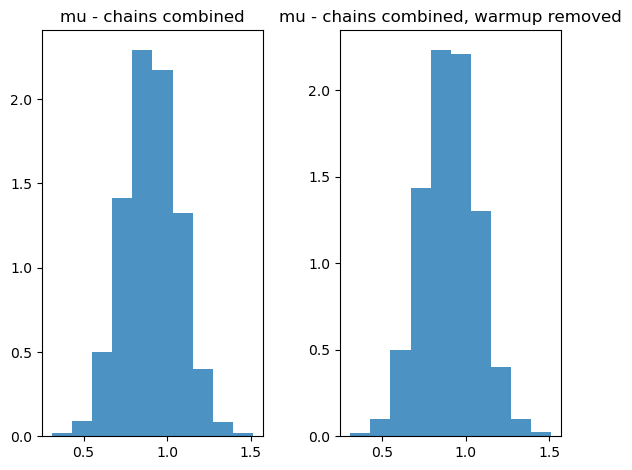

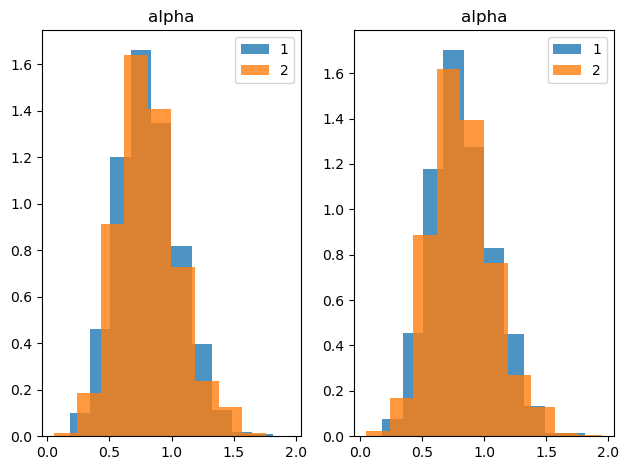

DescribeResult(nobs=3000, minmax=(0.0509105, 1.94856), mean=0.8253952475666665, variance=0.0608210157317228, skewness=0.39003373299005617, kurtosis=0.20942191039715707)


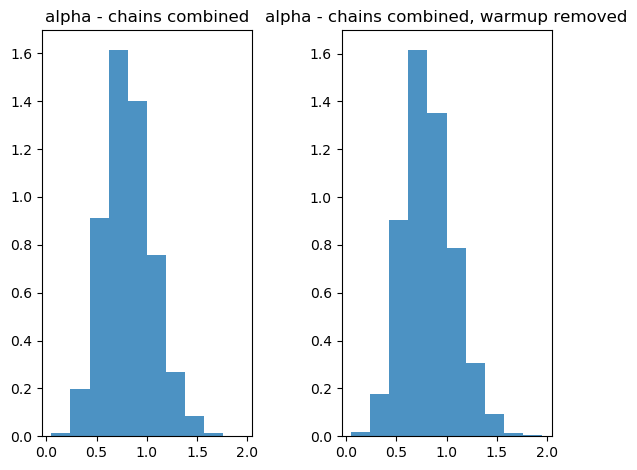

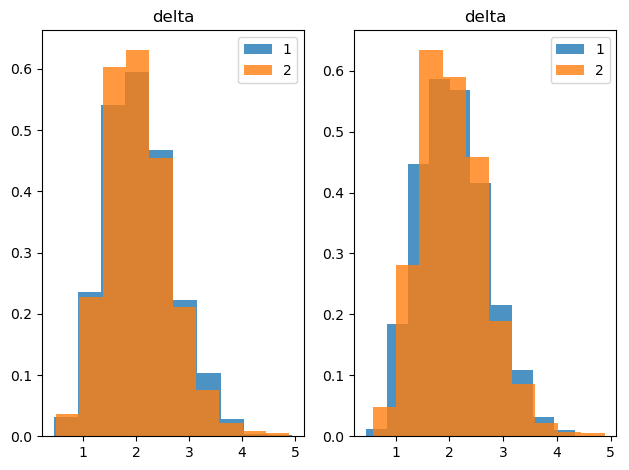

DescribeResult(nobs=3000, minmax=(0.452065, 4.88915), mean=2.0775626396666667, variance=0.39143247043581764, skewness=0.5257993184806796, kurtosis=0.34436695297830466)


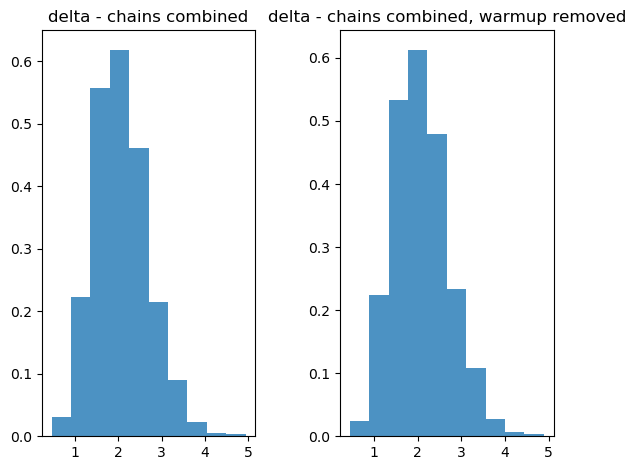

In [45]:
for param_string in ['mu', 'alpha', 'delta']:
    plt.subplot(1, 2, 1)
    plt.hist(df_chain1[param_string].values, alpha=0.8, density=True, label="1")
    plt.hist(df_chain2[param_string].values, alpha=0.8, density=True, label="2")
    plt.legend()
    plt.title(param_string)

    plt.subplot(1, 2, 2)
    plt.hist(df_chain1[param_string].values[warmup:], alpha=0.8, density=True, label="1")
    plt.hist(df_chain2[param_string].values[warmup:], alpha=0.8, density=True, label="2")
    plt.title(param_string)
    plt.legend()

    plt.tight_layout()
    plt.show()

    plt.subplot(1, 2, 1)
    plt.hist(df[param_string].values, alpha=0.8, density=True)
    plt.title(f'{param_string} - chains combined')

    plt.subplot(1, 2, 2)
    plt.hist(df[df['iter__']>warmup][param_string].values, alpha=0.8, density=True)
    plt.title(f'{param_string} - chains combined, warmup removed')

    print(describe(df[df['iter__']>warmup][param_string].values))

    plt.tight_layout()
    plt.show()

Removing warmup samples decreases outliers and variability.

In [46]:
df.head()

,chain__,iter__,draw__,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,alpha,delta,hawkes_log_likelihood
0,1.0,1.0,1.0,-84.4145,0.675187,0.125000,2.0,3.0,0.0,88.8003,0.692503,0.299256,0.670711,-81.6324
1,1.0,2.0,2.0,-84.4145,0.000000,7.969740,0.0,1.0,1.0,84.8171,0.692503,0.299256,0.670711,-81.6324
2,1.0,3.0,3.0,-84.4145,0.000000,1.130630,0.0,1.0,1.0,85.0488,0.692503,0.299256,0.670711,-81.6324
3,1.0,4.0,4.0,-83.8814,0.999573,0.100911,3.0,7.0,0.0,85.7211,0.983641,0.253395,0.936676,-81.5990
4,1.0,5.0,5.0,-79.7645,0.805866,0.128061,3.0,15.0,0.0,84.9904,0.906497,0.507692,1.441750,-79.1711


In [47]:
log_lik_via_python = []

for index, row in df.iterrows():

    mu = row['mu']
    alpha = row['alpha']
    delta = row['delta']

    params = mu, alpha, delta

    log_lik_via_python.append(log_likelihood(params, [hawkes_realisation, max_T]))

In [49]:
np.allclose(np.array(log_lik_via_python), df['hawkes_log_likelihood'].values)

True

Yay! Stan version of likelihood works.

## Playing around with pathfinder and other bits

In [34]:
params = []
for param_string in ['mu', 'alpha', 'delta']:
    params.append(df_chain1.iloc(0)[0][param_string])

In [36]:
mu, alpha, delta = params

In [39]:
print(mu, alpha, delta)

0.939554 1.01281 1.9207


In [42]:
log_likelihood([0.760928, 1.775070, 2.80708], [hawkes_realisation, max_T])

-84.24317192476536

In [38]:
df_chain1

,chain__,iter__,draw__,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,alpha,delta
0,1.0,1.0,1.0,-79.8291,0.824068,0.365407,2.0,7.0,0.0,80.2271,0.939554,1.012810,1.92070
1,1.0,2.0,2.0,-83.2919,0.976761,0.365407,3.0,7.0,0.0,84.5612,0.760928,1.775070,2.80708
2,1.0,3.0,3.0,-80.4312,1.000000,0.365407,2.0,3.0,0.0,83.6103,0.779215,1.445080,2.79007
3,1.0,4.0,4.0,-79.4363,0.999335,0.365407,2.0,3.0,0.0,80.4319,0.797568,1.263360,2.62164
4,1.0,5.0,5.0,-79.2882,0.999486,0.365407,2.0,3.0,0.0,79.5358,0.826247,1.236760,2.67862
...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,1.0,746.0,746.0,-79.9148,0.961875,0.365407,4.0,15.0,0.0,81.9252,1.153600,0.740238,2.18645
746,1.0,747.0,747.0,-79.7463,0.968586,0.365407,4.0,15.0,0.0,81.4204,0.822806,0.547581,1.19752
747,1.0,748.0,748.0,-78.6737,0.993399,0.365407,3.0,11.0,0.0,81.3354,0.814404,1.071330,2.30514
748,1.0,749.0,749.0,-80.3146,0.615719,0.365407,2.0,7.0,0.0,83.4729,1.098280,0.679775,2.82158


In [68]:
fit = model_compiled.pathfinder(data=data,
                            seed=123,
                            num_paths=2,
                            num_single_draws=100,
                            inits=inits,
                            refresh=500,
                            show_console=True)

15:33:16 - cmdstanpy - INFO - Chain [1] start processing


Chain [1] method = pathfinder
Chain [1] pathfinder
Chain [1] init_alpha = 0.001 (Default)
Chain [1] tol_obj = 1e-012 (Default)
Chain [1] tol_rel_obj = 10000 (Default)
Chain [1] tol_grad = 1e-008 (Default)
Chain [1] tol_rel_grad = 1e+007 (Default)
Chain [1] tol_param = 1e-008 (Default)
Chain [1] history_size = 5 (Default)
Chain [1] num_psis_draws = 1000 (Default)
Chain [1] num_paths = 2
Chain [1] save_single_paths = 0 (Default)
Chain [1] psis_resample = 1 (Default)
Chain [1] calculate_lp = 1 (Default)
Chain [1] max_lbfgs_iters = 1000 (Default)
Chain [1] num_draws = 100
Chain [1] num_elbo_draws = 25 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = C:\Users\ethan\AppData\Local\Temp\tmpjt44hyuy\_6gmy5d_.json
Chain [1] init = C:\Users\ethan\AppData\Local\Temp\tmpjt44hyuy\pnl7d_tl.json
Chain [1] random
Chain [1] seed = 123
Chain [1] output
Chain [1] file = C:\Users\ethan\AppData\Local\Temp\tmpjt44hyuy\simple_exp_hawkes_3woedea\simple_exp_hawkes-20240409153316.csv
Chain [1

15:33:17 - cmdstanpy - INFO - Chain [1] done processing


Chain [1] Path [2] : Iter      log prob        ||dx||      ||grad||     alpha      alpha0      # evals       ELBO    Best ELBO        Notes
Chain [1] 12     -7.833e+001     2.037e-003  1.366e-004   1.000e+000 1.000e+000       301-8.359e+001-8.359e+001
Chain [1] Path [2] :Best Iter: [9] ELBO (-83.204211) evaluations: (301)
Chain [1] Total log probability function evaluations:752
Chain [1] Pareto k value (1.187947) is greater than 0.7. Importance resampling was not able to improve the approximation, which may indicate that the approximation itself is poor.
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 

In [60]:
fit.stan_variables()['mu']

array([1.18176 , 0.728595, 0.990306, 0.914655, 0.618157, 0.981049,
       0.825713, 0.681188, 0.916522, 0.801286, 0.942752, 0.707354,
       0.89012 , 0.955772, 0.746629, 0.817274, 0.956404, 0.785119,
       1.09885 , 1.02732 , 0.886746, 1.16103 , 0.921474, 1.00026 ,
       1.02552 , 1.31767 , 0.89012 , 0.719328, 0.866104, 0.866778,
       0.866104, 1.01045 , 0.956537, 0.641095, 0.878657, 1.3174  ,
       0.768842, 1.11474 , 0.752578, 0.662531, 0.948067, 0.731942,
       0.822323, 0.860878, 0.568737, 0.967214, 0.908588, 0.871527,
       1.03943 , 1.03683 , 0.722371, 1.01727 , 0.982309, 0.956404,
       0.80118 , 0.912561, 0.931089, 0.813172, 0.805177, 0.772188,
       0.795021, 0.858681, 1.07649 , 1.24081 , 1.0247  , 0.95405 ,
       0.974022, 0.864427, 0.919185, 0.856699, 0.775288, 0.916615,
       0.698403, 1.29963 , 0.789531, 0.986605, 0.914655, 0.834493,
       0.921588, 0.843985, 0.893455, 0.800856, 0.888012, 1.06138 ,
       0.697594, 0.794705, 0.962437, 0.764399, 0.912785, 0.713

In [65]:
fit.draws()[:,2]

array([1.18176 , 0.728595, 0.990306, 0.914655, 0.618157, 0.981049,
       0.825713, 0.681188, 0.916522, 0.801286, 0.942752, 0.707354,
       0.89012 , 0.955772, 0.746629, 0.817274, 0.956404, 0.785119,
       1.09885 , 1.02732 , 0.886746, 1.16103 , 0.921474, 1.00026 ,
       1.02552 , 1.31767 , 0.89012 , 0.719328, 0.866104, 0.866778,
       0.866104, 1.01045 , 0.956537, 0.641095, 0.878657, 1.3174  ,
       0.768842, 1.11474 , 0.752578, 0.662531, 0.948067, 0.731942,
       0.822323, 0.860878, 0.568737, 0.967214, 0.908588, 0.871527,
       1.03943 , 1.03683 , 0.722371, 1.01727 , 0.982309, 0.956404,
       0.80118 , 0.912561, 0.931089, 0.813172, 0.805177, 0.772188,
       0.795021, 0.858681, 1.07649 , 1.24081 , 1.0247  , 0.95405 ,
       0.974022, 0.864427, 0.919185, 0.856699, 0.775288, 0.916615,
       0.698403, 1.29963 , 0.789531, 0.986605, 0.914655, 0.834493,
       0.921588, 0.843985, 0.893455, 0.800856, 0.888012, 1.06138 ,
       0.697594, 0.794705, 0.962437, 0.764399, 0.912785, 0.713